In [1]:
'''
Rice grain quality recognition project
1.Build data structure for Mask_RCNN
    - setup training data heiarchy
    - parse and load image and annotation file
    

'''

'\nRice grain quality recognition project\n1.Build data structure for Mask_RCNN\n    - setup training data heiarchy\n    - parse and load image and annotation file\n    \n\n'

In [2]:
import cv2
import os
import re
import json
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mrcnn.utils import Dataset

%matplotlib notebook
warnings.filterwarnings('ignore')

train_dir = os.getcwd() + '/training/'

/Users/kyy/riceCV/envrice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kyy/riceCV/envrice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kyy/riceCV/envrice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kyy/riceCV/envrice/lib/python3.7/site-packages/tensorflow/python/f

In [3]:
def extract_boxes(filename):
    
    with open(filename) as f:
        ann = json.load(f)
        
    height = ann['imageHeight']
    width = ann['imageWidth']
    all_boxes = ann['shapes']
    
    boxes = [(shape['label'], 
            np.array(shape['points'], 
            dtype=np.int16)) for shape in all_boxes]
    return height, width, boxes

In [4]:
class riceDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        
        images_dir = dataset_dir + 'imgs/'
        annots_dir = dataset_dir + 'annots/'
        
        with open(dataset_dir + 'train_labels.csv') as tl:
            labels = re.split('[,\n]', tl.read()[:-1])
            print('labels: ', labels)
        
        for i, label in zip(range(len(labels)), labels):
            self.add_class('dataset', i, label)
        
        for filename in os.listdir(images_dir):
            image_id = filename[:-4]
            image_path = images_dir + filename
            annots_path = annots_dir + image_id + '.json'
            
            height, width, boxes = extract_boxes(annots_path)
            self.add_image('dataset', 
                           image_id=image_id, 
                           path=image_path,
                           width=width,
                           height=height,
                           boxes=boxes,
                           annotation=annots_path)
        
    def load_mask(self, image_id):
        
        info = self.image_info[image_id]
        path = info['annotation']
        masks = np.zeros([info['height'], 
                          info['width'], 
                          len(info['boxes'])], dtype='uint8')
        
        class_ids = []
        for i in range(len(info['boxes'])):
            box = info['boxes'][i]
            row_s, row_e = box[1][0][0], box[1][1][0]
            col_s, col_e = box[1][0][1], box[1][1][1]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(box[0]))
        
        return masks, np.asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        
        info = self.image_info[image_id]
        return info['path']

In [5]:
train = riceDataset()
train.load_dataset(train_dir, is_train=True)
train.prepare()
print('Train: %d' % len(train.image_ids))

labels:  ['bad', 'full', 'cracked', 'heat', 'white']
Train: 6


In [6]:
image_id = 0
image = train.load_image(image_id)
print(image.shape)

mask, class_ids = train.load_mask(image_id)
print(mask.shape)

(1706, 960, 3)
(1706, 960, 37)


<IPython.core.display.Javascript object>


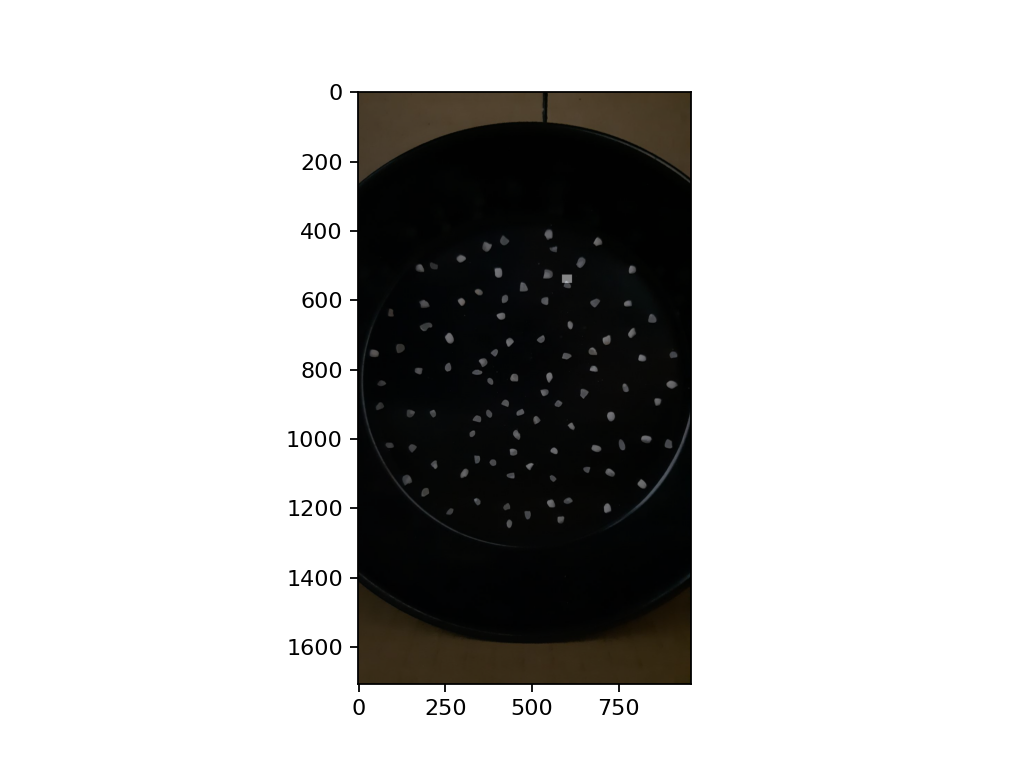

In [7]:
from matplotlib import interactive
interactive(True)
plt.imshow(image)
plt.imshow(mask[:, :, 1], cmap='gray', alpha=.5)
plt.show()

In [8]:

# rice_data = riceDataset()
# h, w, data = extract_polygon('./training/annots/bad.json')
# rice_data.load_dataset(train_dir)